In [16]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")

In [35]:
df = pd.read_csv("steam-200k.csv", header=None, index_col=None, names=['userid', 'gamename', 'gtype', 'hrs', 'Other'])
print(df.shape)
df.head()

(200000, 5)


,userid,gamename,gtype,hrs,Other
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   userid    200000 non-null  int64  
 1   gamename  200000 non-null  object 
 2   gtype     200000 non-null  object 
 3   hrs       200000 non-null  float64
 4   Other     200000 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 7.6+ MB


In [37]:
df[df.duplicated()]   # duplicate rows

,userid,gamename,gtype,hrs,Other
1968,11373749,Sid Meier's Civilization IV,purchase,1.0,0
1970,11373749,Sid Meier's Civilization IV Beyond the Sword,purchase,1.0,0
1972,11373749,Sid Meier's Civilization IV Warlords,purchase,1.0,0
2724,56038151,Grand Theft Auto San Andreas,purchase,1.0,0
2726,56038151,Grand Theft Auto Vice City,purchase,1.0,0
...,...,...,...,...,...
194392,39146470,Sid Meier's Civilization IV Warlords,purchase,1.0,0
195517,48666962,Crysis 2,purchase,1.0,0
195821,112845094,Grand Theft Auto San Andreas,purchase,1.0,0
195823,112845094,Grand Theft Auto Vice City,purchase,1.0,0


In [38]:
print("Number of games : {0}".format(len(df.gamename.unique())))
print("Number of users : {0}".format(len(df.userid.unique())))
print("Number of total purchases : {0}".format(len(df.loc[df['gtype'] == 'purchase'])))
print("Number of total plays infos : {0}".format(len(df.loc[df['gtype'] == 'play'])))

Number of games : 5155
Number of users : 12393
Number of total purchases : 129511
Number of total plays infos : 70489


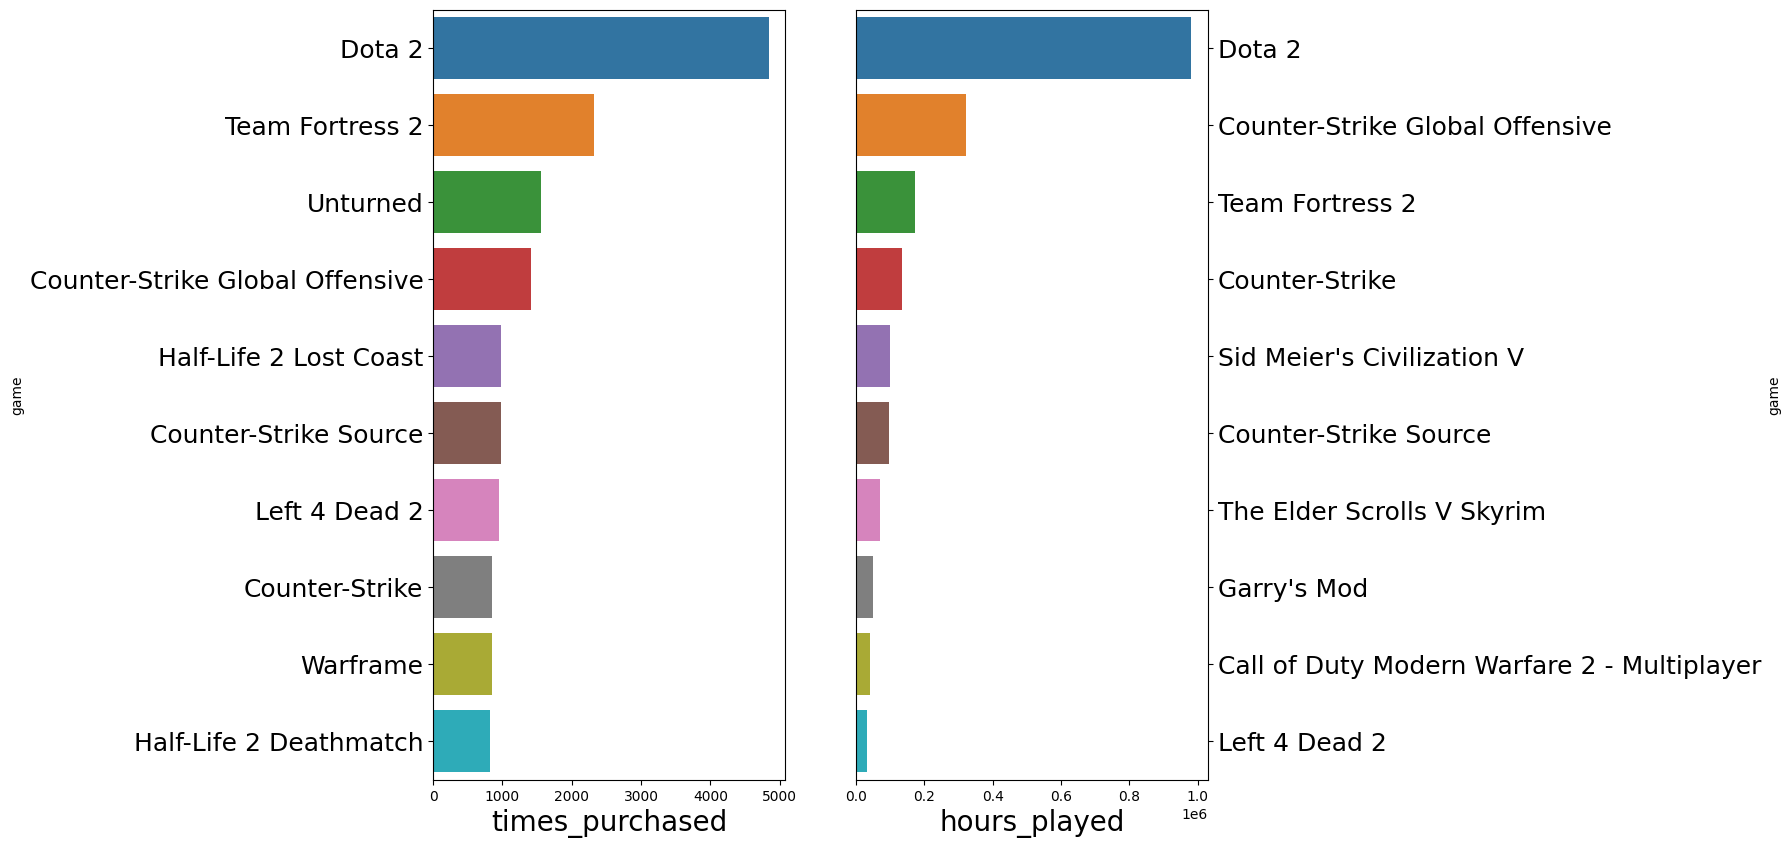

In [39]:
nb_games = 10
df_purchase = df.loc[df['gtype'] == 'purchase']
purchased_times = df_purchase.groupby('gamename')['gamename'].agg('count').sort_values(ascending=False)
purchased_times = pd.DataFrame({'game': purchased_times.index, 'times_purchased': purchased_times.values})[0:nb_games]

df_play = df.loc[df['gtype'] == 'play']
hours_played = df_play.groupby('gamename')['hrs'].agg(np.sum).sort_values(ascending=False)
hours_played = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:nb_games]

fig, ax =plt.subplots(1,2,figsize=(10,nb_games))

sns.barplot(y = 'game', x = 'times_purchased', data = purchased_times, ax=ax[0])
sns.barplot(y = 'game', x = 'hours_played', data = hours_played, ax=ax[1])


ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
for i in range(0,2):
    ax[i].tick_params(axis='y', labelsize=18)
    ax[i].xaxis.label.set_size(20)

In [40]:
# %%writefile prep.py

# import numpy as np
# import pandas as pd
# from sklearn import preprocessing

# import warnings
# warnings.filterwarnings("ignore")

def prep(df):

    df.drop_duplicates(keep='last', inplace=True)
    df= df[(df['hrs']>=2) & (df['gtype']=='play')]
    df = df[df.groupby('gamename').userid.transform(len)>=10]

    average = df.groupby(['gamename'],as_index = False).hrs.mean()
    average.rename(columns = {'hrs':'avg_hrs'}, inplace = True)
    df = df.merge(average,on = 'gamename')

    condition = [
                    df['hrs']>= (0.8*df['avg_hrs']),
                    (df['hrs']>=0.6*df['avg_hrs'])&(df['hrs']<0.8*df['avg_hrs']),
                    (df['hrs']>=0.4*df['avg_hrs'])&(df['hrs']<0.6*df['avg_hrs']),
                    (df['hrs']>=0.2*df['avg_hrs'])&(df['hrs']<0.4*df['avg_hrs']),
                    df['hrs']>=0
                ]

    values = [5,4,3,2,1]
    df['rating'] = np.select(condition,values)
    final_df = df[['userid', 'gamename', 'rating']]

    user_le = preprocessing.LabelEncoder()
    user_le.fit(final_df['userid'])
    final_df['userid'] = user_le.transform(final_df['userid'])

    game_le = preprocessing.LabelEncoder()
    game_le.fit(final_df['gamename'])
    final_df['gamename'] = game_le.transform(final_df['gamename'])

    train_ind = []
    test_ind = []

    np.random.seed(0)
    for user_id in final_df['userid'].unique():
        examples = list(final_df[final_df['userid'] == user_id].index)
        np.random.shuffle(examples)

        if(len(examples)>5):
            # store 80% of the examples in train and the rest in test
            train_ind += examples[ : int(0.8*len(examples))]
            test_ind += examples[int(0.8*len(examples)) : ]

    train = final_df.loc[train_ind, :].reset_index(drop=True)
    test = final_df.loc[test_ind, :].reset_index(drop=True)

    return train, test, user_le, game_le

In [41]:
train, test, user_le, game_le = prep(df)
train.shape, test.shape

((22641, 3), (6500, 3))

In [42]:
# %%writefile eval.py

# import numpy as np
# import pandas as pd
# from sklearn import preprocessing

# import warnings
# warnings.filterwarnings("ignore")

def evaluate(pred, test, userid, game_le, user_le):
    user_ind = user_le.transform(np.array([userid]))[0]
    actual_liked = test[(test['userid']==user_ind) & (test['rating']>=3)]['gamename'].values
    actual_disliked = test[(test['userid']==user_ind) & (test['rating']<3)]['gamename'].values
    pred = game_le.transform(pred['gamename'])

    tp = len(set(actual_liked).intersection(set(pred)))
    fp = len(set(actual_disliked).intersection(set(pred)))
    fn = len(set(actual_liked) - set(pred))
    

    precision = tp/(tp+fp) if (tp+fp)!=0 else 0
    recall = tp/(tp+fn) if (tp+fn)!=0 else 0
    f1 = 2*precision*recall/(precision+recall) if (precision+recall)!=0 else 0

    print('Precision@10 :', precision)
    print('Recall@10 :', recall)
    print('F1@10 :', f1)

## Section-1

In [43]:
# %%writefile user_based.py

# import numpy as np
# import pandas as pd
# from sklearn import preprocessing
# from sklearn.metrics.pairwise import cosine_similarity

# import warnings
# warnings.filterwarnings("ignore")

def helper(train):

    user_gamename_mat = train.pivot_table(index="userid",columns="gamename",values="rating") 

    meanmapper = user_gamename_mat.copy()
    meanmapper["meaner"] = meanmapper.mean(axis=1)  
    meanmapper = meanmapper[["meaner"]]

    user_gamename_mat = user_gamename_mat.subtract(user_gamename_mat.mean(axis=1),axis=0)
    normed = user_gamename_mat.subtract(user_gamename_mat.mean(axis=1),axis=0)  
    normed = normed.fillna(0) 
    sim_mat_user = cosine_similarity(normed)  
    sim_mat_user = pd.DataFrame(sim_mat_user,columns=normed.index.values,index = normed.index.values)

    return user_gamename_mat, meanmapper, sim_mat_user

def user_based(user_gamename_mat, meanmapper, sim_mat_user, userid, user_le, game_le, k=5, n=10):

    user = user_le.transform([userid])[0]
    rem_sim_mat = sim_mat_user.drop(index=user)   
    simusers = rem_sim_mat[user].sort_values(ascending=False)[:k]
    # print(simusers)

    already_watch = user_gamename_mat[user_gamename_mat.index==user].dropna(axis=1,how='all')
    # print(already_watch)
    simi_user_seen = user_gamename_mat[user_gamename_mat.index.isin(simusers.index)].dropna(axis=1,how='all')
    simi_user_seen.drop(already_watch.columns,axis=1,inplace=True,errors="ignore")  
    # print(simi_user_seen)

    pred_df = pd.DataFrame(columns=["gamename","rating"])
    for i in simi_user_seen.columns:  
        score = meanmapper.loc[user]["meaner"] 

        movie_rating = simi_user_seen[i]
        for u in simusers.index:
            if pd.isna(movie_rating[u])==False:
                number_of_common_rated = (user_gamename_mat.loc[user].notnull() & user_gamename_mat.loc[u].notnull()).sum()
                if(number_of_common_rated > k):      
                    number_of_common_rated = k
                if(sim_mat_user.loc[user][u]*number_of_common_rated > 0):
                    score = score + sim_mat_user.loc[user][u]*movie_rating[u]*number_of_common_rated/abs(sim_mat_user.loc[user][u]*number_of_common_rated) 
        
        if(score>5):
            score = 5
        elif(score<1):
            score = 1

        pred_df = pred_df.append({"gamename": game_le.inverse_transform(np.array([i]))[0], "rating":score},ignore_index=True)

    pred_df = pred_df.sort_values(by='rating', ascending=False).reset_index(drop=True)
    pred_df['rating'] = pred_df['rating'].apply(lambda x:round(x))
    pred_df['rating'] = pred_df['rating'].apply(lambda x:5 if x>5 else x)
    pred_df['rating'] = pred_df['rating'].apply(lambda x:1 if x<1 else x)
    
    return pred_df[:n]

In [44]:
user_gamename_mat, meanmapper, sim_mat_user = helper(train)

In [45]:
pred = user_based(user_gamename_mat, meanmapper, sim_mat_user, 48845802, user_le, game_le)
pred

,gamename,rating
0,Call of Duty Modern Warfare 2 - Multiplayer,5
1,Call of Duty Modern Warfare 2,5
2,Risen 2 - Dark Waters,5
3,Counter-Strike,4
4,Day of Defeat,4
5,Turbo Dismount,4
6,Empire Total War,4
7,Battlefield Bad Company 2,4
8,Just Cause 2,4
9,NBA 2K15,3


In [46]:
evaluate(pred, test, 48845802, game_le, user_le)

Precision@10 : 1.0
Recall@10 : 1.0
F1@10 : 1.0


## Section-2

In [47]:
# %%writefile mat_fact.py

# import numpy as np
# import pandas as pd

# import warnings
# warnings.filterwarnings("ignore")

def matrix_factorization(train, K=10, steps=30, alpha=0.01, beta=0.01):

    util_df = pd.pivot_table(data=train,values='rating',index='userid',columns='gamename')
    util_df.fillna(0, inplace=True)

    R = np.array(util_df)
    P = np.random.rand(len(R), K)
    Q = np.random.rand(len(R[0]), K).T
    
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])  # calculate error

                    for k in range(K):
                        # calculate gradient with alpha and beta parameter
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])

        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)

        rmse = np.sqrt(e/len(R[R>0]))
        # print('step :', step+1, 'RMSE :', rmse)
        if rmse < 0.01:
            break

    return P, Q.T, util_df

def recommend(user_id, nR, util_df, user_le, game_le, n=10):
    user_ind = user_le.transform(np.array([user_id]))[0]
    user_idx = np.where(util_df.index == user_ind)[0][0]
    # print(user_ind)
    unrated_gamename = util_df.loc[user_ind][util_df.loc[user_ind] == 0].index

    unrated_gamename_df = pd.DataFrame()
    unrated_gamename_df['gamename'] = game_le.inverse_transform(unrated_gamename)
    unrated_gamename_df['rating'] = nR[user_idx][unrated_gamename]
    unrated_gamename_df = unrated_gamename_df.sort_values(by='rating', ascending=False).reset_index(drop=True)

    unrated_gamename_df['rating'] = unrated_gamename_df['rating'].apply(lambda x:round(x))
    unrated_gamename_df['rating'] = unrated_gamename_df['rating'].apply(lambda x:5 if x>5 else x)
    unrated_gamename_df['rating'] = unrated_gamename_df['rating'].apply(lambda x:1 if x<1 else x)
    
    return unrated_gamename_df[:n]

In [48]:
nP, nQ, util_df = matrix_factorization(train)
nR = np.dot(nP, nQ.T)

In [27]:
pred = recommend(53875128, nR, util_df, user_le, game_le, n=10)
pred

,gamename,rating
0,Dota 2,5
1,Democracy 3,5
2,Clicker Heroes,5
3,Borderlands The Pre-Sequel,5
4,DayZ,5
5,Turbo Dismount,5
6,Global Agenda,5
7,Counter-Strike Global Offensive,5
8,Darksiders,5
9,Deus Ex Human Revolution,5


In [28]:
evaluate(pred, test, 53875128, game_le, user_le)

Precision@10 : 0
Recall@10 : 0.0
F1@10 : 0


## Section-3

In [49]:
# %%writefile ltr.py

# import numpy as np
# import pandas as pd
# from sklearn import preprocessing
# from sklearn.ensemble import RandomForestRegressor

# import warnings
# warnings.filterwarnings("ignore")

def LTR(nQ, train, test, userid, user_le, game_le):
    user_ind = user_le.transform(np.array([userid]))[0]
    user_df = train[train['userid']==user_ind]

    x_train = nQ[user_df['gamename']][:]
    y_train = user_df['rating']
    x_test = nQ[test['gamename']][:]

    rf = RandomForestRegressor(n_estimators=500, max_depth=6, min_samples_leaf=8, n_jobs=-1)
    rf.fit(x_train, y_train)

    # show the top 10 games with highest predicted rating
    pred_df = pd.DataFrame()
    pred_df['gamename'] = game_le.inverse_transform(test['gamename'])
    pred_df['rating'] = rf.predict(x_test)
    pred_df = pred_df.sort_values(by='rating', ascending=False).reset_index(drop=True)

    pred_df['rating'] = pred_df['rating'].apply(lambda x:round(x))
    pred_df['rating'] = pred_df['rating'].apply(lambda x:5 if x>5 else x)
    pred_df['rating'] = pred_df['rating'].apply(lambda x:1 if x<1 else x)
    pred_df.drop_duplicates(subset=['gamename'], inplace=True, keep='first')

    return pred_df[:10]

In [50]:
pred = LTR(nQ, train, test, 53875128, user_le, game_le)
pred

,gamename,rating
0,Dishonored (RU),4
1,Prototype,4
2,Bastion,4
14,Awesomenauts,4
19,Mass Effect 2,4
35,Gunpoint,4
38,Just Cause 2,4
65,Crysis 2 Maximum Edition,4
78,Borderlands 2,4
164,Sid Meier's Civilization Beyond Earth,4


## References

> https://www.kaggle.com/code/sumeet07/game-recommender-system
> https://www.kaggle.com/code/simonprevoteaux/steam-game-analysis
> https://fastapi.tiangolo.com